# \[set-up\], imports
Reminder (if working on the notebook server): make sure your copy of `timing_analysis` is up to date and you're working on a development branch, e.g. `psr/J1234+5678/jks`. See README for more details. If not working on the notebook server, you may need to update required software packages (`pint`, `enterprise`, `enterprise_extensions`) according to requirements in `setup.py`.

In [25]:
import timing_analysis.par_checker as pc
import timing_analysis.dmx_utils as du
import timing_analysis.lite_utils as lu
import timing_analysis.noise_utils as nu
import timing_analysis.plot_utils as pu
from timing_analysis.ftester import run_Ftests
from timing_analysis.utils import resid_stats, pdf_writer, check_recentness_excision, check_recentness_noise
from timing_analysis.timingconfiguration import TimingConfiguration
from astropy import log
from pint.fitter import ConvergenceFailure
import pint.fitter
from pint.utils import dmxparse
import os
import copy
from astropy.visualization import quantity_support
quantity_support()

# notebook gives interactive plots but not until the kernel is done
%matplotlib notebook
# inline gives non-interactive plots right away
#%matplotlib inline

In [26]:
# default assumption is that notebook is being run by hand
autorun = False
run_Ftest = True  # Set to False if you don't need F-tests and want a faster notebook run!
check_excision = True
num_noise_iter = 2e5

if not autorun:
    run_noise_analysis = False 
    use_existing_noise_dir = True
    use_toa_pickle = True
else:
    run_noise_analysis = True 
    use_existing_noise_dir = False
    use_toa_pickle = False

In [27]:
log.setLevel("INFO") # Set desired verbosity of log statements (DEBUG/INFO/WARNING/ERROR)
log_to_file = False

lu.git_config_info()

INFO: Your git config user.name is:  [timing_analysis.lite_utils]
INFO: ...to change this, in a terminal: git config user.name "First Last" [timing_analysis.lite_utils]
INFO: Your git config user.email is:  [timing_analysis.lite_utils]
INFO: ...to change this, in a terminal: git config user.email "first.last@nanograv.org" [timing_analysis.lite_utils]


# develop/update \[prenoise\] timing solution

Load configuration (`.yaml`) file, get TOAs and timing model; if you're running from the root of the git distribution, simply edit the `.yaml` file name, otherwise include relevant paths to the `.yaml` file, and `.par`/`.tim` directories as kwargs (see commented example).

In [28]:
config = "/nanograv/share/15yr/timing/intermediate/20220304.Outlier.nb.temp/hJ1744-1134.nb.yaml"   # fill in actual path
par_directory = "/nanograv/share/15yr/timing/intermediate/20220304.Outlier.nb.temp"   # default location
tim_directory = "/nanograv/share/15yr/timing/intermediate/20220304.Outlier.nb.temp"  # default location
tc = TimingConfiguration(config, par_directory=par_directory, tim_directory=tim_directory)

using_wideband = tc.get_toa_type() == 'WB'

# Use excise.tim file if it exists, else revert to raw TOAs & initial cuts
mo,to = tc.get_model_and_toas(excised=True,usepickle=use_toa_pickle)
if not to: mo,to = tc.get_model_and_toas(apply_initial_cuts=True)
tc.manual_cuts(to)

if log_to_file:
    lu.log_notebook_to_file(tc.get_source(), tc.get_toa_type())
    lu.log_warnings()

/home/jovyan/.local/lib/python3.9/site-packages/pint/models/timing_model.py:366: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")


INFO: Frontend/backend pairs present in this data set: {'Rcvr1_2_GASP', 'Rcvr_800_GUPPI', 'Rcvr_800_GASP', 'Rcvr1_2_GUPPI'} [timing_analysis.timingconfiguration]
INFO: Rcvr1_2_GASP files: 40 [timing_analysis.timingconfiguration]
INFO: Rcvr_800_GUPPI files: 85 [timing_analysis.timingconfiguration]
INFO: Rcvr_800_GASP files: 40 [timing_analysis.timingconfiguration]
INFO: Rcvr1_2_GUPPI files: 89 [timing_analysis.timingconfiguration]
INFO: Specified TOA excision keys: {'mjd-end', 'snr-cut'} [timing_analysis.timingconfiguration]
INFO: Selecting 12487 TOAs out of 12487 (0 removed based on initial cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 12487 TOAs out of 12487 (0 removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 12487 TOAs out of 12487 (0 removed based on manual cuts, specified 

In [29]:
# Computing pulse numbers ensures param changes in the model will not break phase connection
to.compute_pulse_numbers(mo)

In [30]:
# Ensure DMX windows are calculated properly, set non-binary epochs to the center of the data span
to = du.setup_dmx(mo,to,frequency_ratio=tc.get_fratio(),max_delta_t=tc.get_sw_delay())
lu.center_epochs(mo,to)
if not autorun: to.print_summary()

INFO: Updated mean DM parameter from 3.0923820 to 3.0939992. [timing_analysis.dmx_utils]
INFO: Proposed DMX model OK. [timing_analysis.dmx_utils]
INFO: Removed 133 DMX parameters from timing model. [timing_analysis.dmx_utils]
INFO: Added 133 DMX parameters to timing model. [timing_analysis.dmx_utils]
Number of TOAs:  12487
Number of commands:  [2]
Number of observatories: 1 ['gbt']
MJD span:  53216.127 to 57922.230
Date span: 2004-07-30 03:02:25.265271560 to 2017-06-18 05:31:44.690131319
gbt TOAs (12487):
  Min freq:      725.319 MHz
  Max freq:      1882.406 MHz
  Min error:     0.04 us
  Max error:     14 us
  Median error:  0.995 us



Run basic checks for pulsar name, solar system ephemeris, clock correction, ecliptic coordinates, tropospheric delays, planet Shapiro delays, and if applicable, removal of Arecibo data affected by bad LO. Check that TOAs being used are from the latest `toagen` release. Also check for the appropriate number of receiver JUMPs and DMJUMPs and fix them automatically if necessary.

In [31]:
pc.check_settings(mo,to)

receivers = lu.get_receivers(to)
lu.add_feJumps(mo,receivers)
if using_wideband:
    lu.add_feDMJumps(mo,receivers)
pc.check_jumps(mo,receivers,toa_type=tc.get_toa_type())

if not autorun: check_recentness_excision(tc)

INFO: PSR parameter is J1744-1134. [timing_analysis.par_checker]
INFO: Current Solar System ephemeris in use is DE440. [timing_analysis.par_checker]
INFO: BIPM version in use is BIPM2019. [timing_analysis.par_checker]
INFO: AstrometryEcliptic in model components. [timing_analysis.par_checker]
INFO: CORRECT_TROPOSPHERE is set to True. [timing_analysis.par_checker]
INFO: PLANET_SHAPIRO is set to True. [timing_analysis.par_checker]
INFO: Exactly one frontend not JUMPed. [timing_analysis.lite_utils]


ERROR: TOAs from multiple releases should not be combined: {None, '20170425'} [timing_analysis.par_checker]


<IPython.core.display.Javascript object>


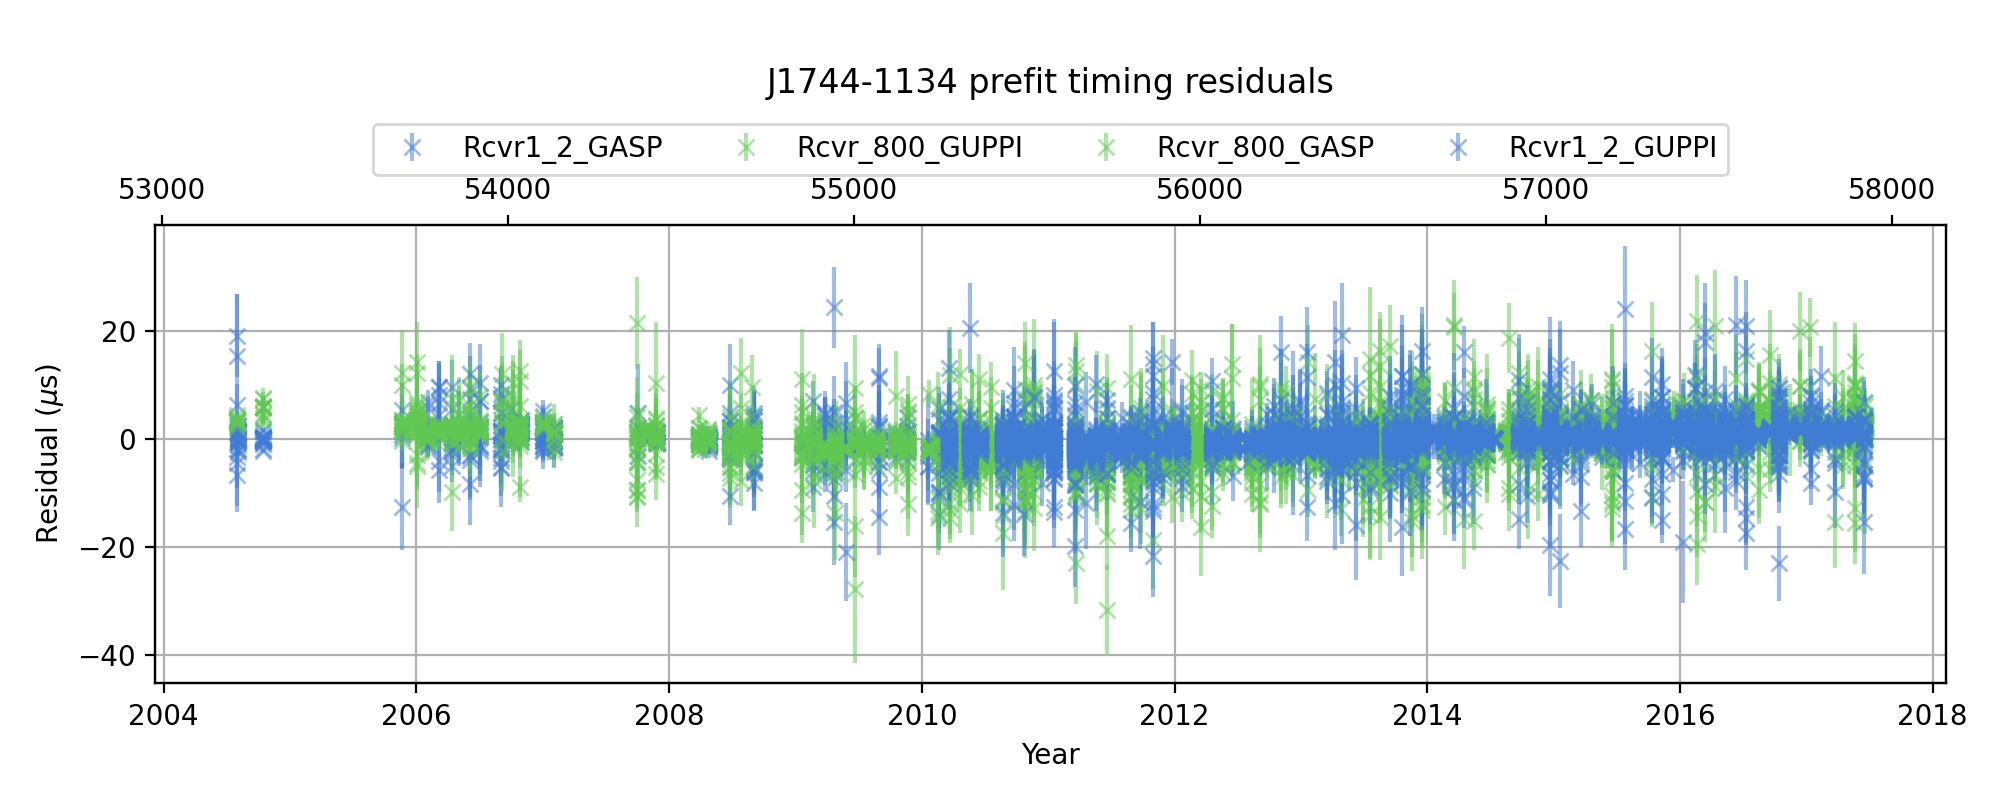

In [32]:
# Define the fitter object and plot pre-fit residuals
fo = tc.construct_fitter(to,mo)
pu.plot_residuals_time(fo, restype='prefit')
if mo.is_binary:
    pu.plot_residuals_orb(fo, restype='prefit')
if using_wideband:
    pu.plot_dm_residuals(fo, restype='prefit')

In [33]:
# Check that free-params follow NANOGrav conventions, fit
fo.model.free_params = tc.get_free_params(fo)
lu.check_fit(fo,skip_check=tc.skip_check)

try:
    fo.fit_toas(maxiter=tc.get_niter())
    fo.model.CHI2.value = fo.resids.chi2
except ConvergenceFailure:
    run_Ftest = False
    log.warning('Failed to converge; moving on with best result, but should address before final version.')

<IPython.core.display.Javascript object>


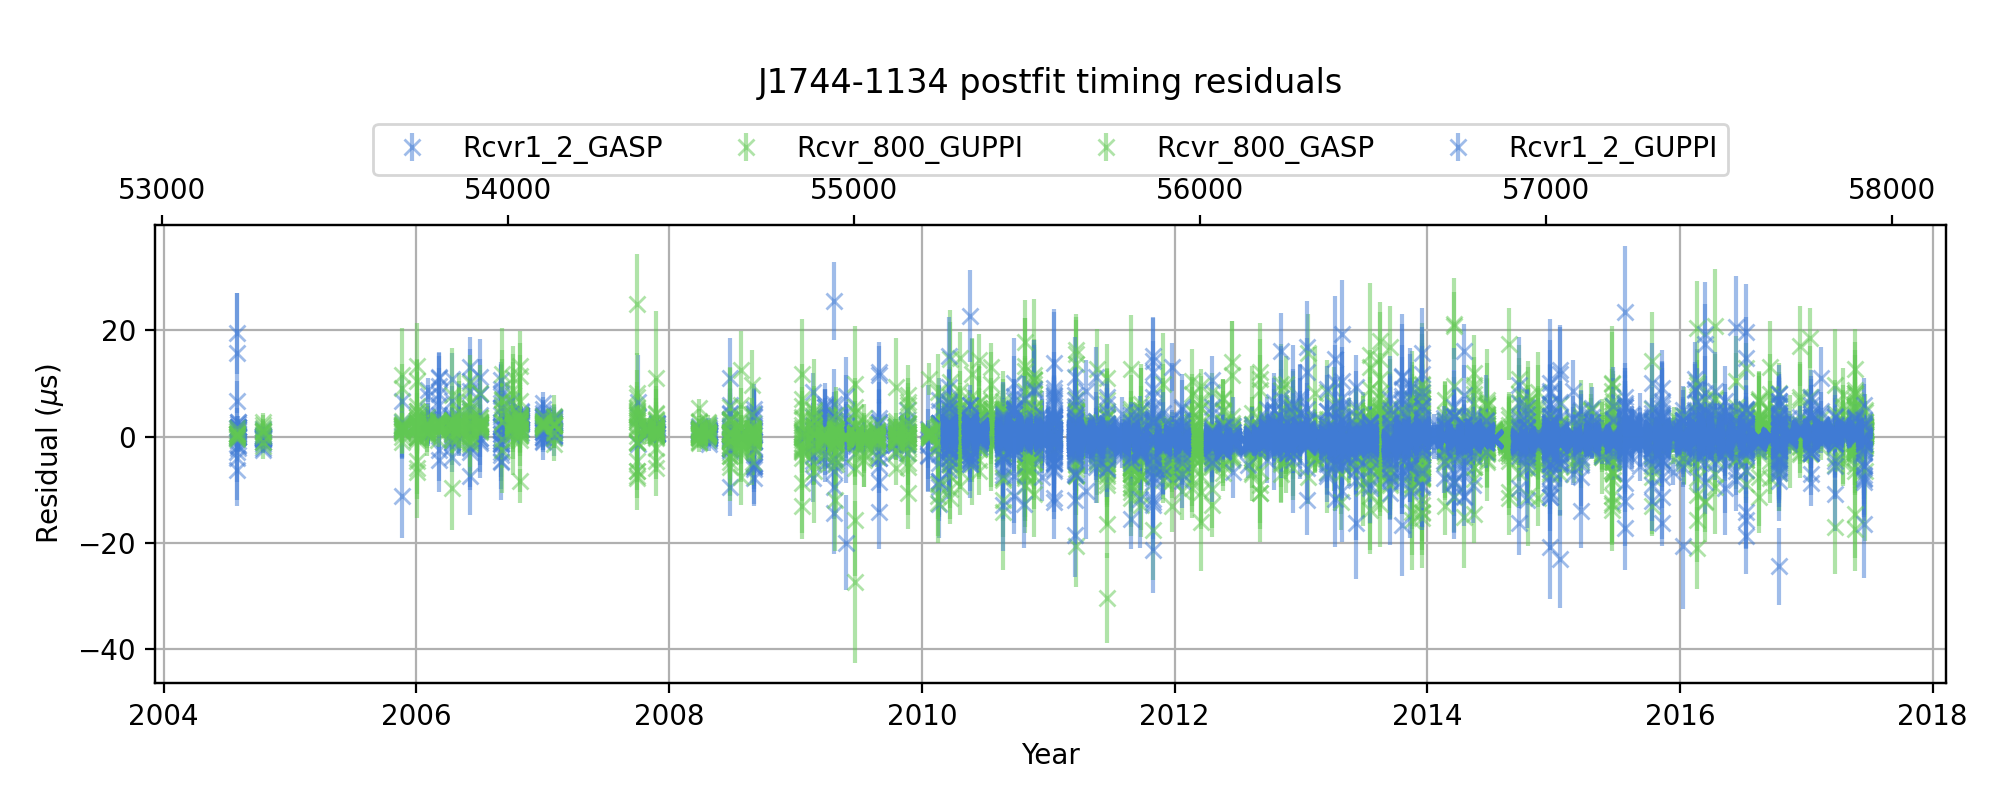

Fitted model using downhill_gls method with 145 free parameters to 12487 TOAs
Prefit residuals Wrms = 1.5953816115955468 us, Postfit residuals Wrms = 1.1506425333848855 us
Chisq = 16131.328 for 12341 d.o.f. for reduced Chisq of 1.307

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           J1744-1134 J1744-1134                   None
EPHEM                              DE436 DE440                        None
CLOCK                       TT(BIPM2017) TT(BIPM2019)                 None
UNITS                                TDB TDB                          None
START                            53216.1                      53216.1 d 
FINISH                           57922.2                      57922.2 d 
INFO                                  -f -f                           None
TIMEEPH                             FB90 FB90                         None
T2CMETHOD        

chi-squared decreased during fit by 4088.4039782315017
Fitter has converged


In [34]:
# Plot post-fit residuals, print summary of results, write prenoise solution
pu.plot_residuals_time(fo, restype='postfit')
if mo.is_binary:
    pu.plot_residuals_orb(fo, restype='postfit')
if using_wideband:
    pu.plot_dm_residuals(fo, restype='postfit')
    
if not autorun: fo.print_summary()
lu.check_convergence(fo)

lu.write_par(fo,toatype=tc.get_toa_type(),addext='_prenoise')

# \[noise\] analysis, re-fit

Noise analysis runs are required for the 15-yr v1.0 data set, using the latest available timing model and set of TOAs. If TOA excision or free parameters are changed in the `.yaml`/`.par` file(s), new noise model parameters should be generated before proceeding. Use the [prenoise] section of this notebook to improve TOA excision, ensure residuals are flat, then submit a merge request with that solution, and wait for noise results to be made available. See the "Automatic Runs on Thorny Flats" wiki to request new runs, or make a note for your pulsar(s) in the who-which page.

We strongly discourage running noise analyses from on the notebook server, since doing so can take several hours (or days!) to complete and hogs lots of shared resources. Set `run_noise_analysis = False` unless you have a good reason to do otherwise.

In [ ]:
noise_dir = None   # fill in directory name here if appropriate
compare_noise_dir = None   # fill in directory name here if appropriate
fo_noise = fo      # fallback in case the noise model can't be found
if noise_dir is not None:
    tc.config['intermediate-results']['noise-dir'] = noise_dir
if compare_noise_dir is not None:
    tc.config['intermediate-results']['compare-noise-dir'] = compare_noise_dir
print(f"Looking for noise chains in {tc.get_noise_dir()}")

In [ ]:
if not autorun: check_recentness_noise(tc);

If `run_noise_analysis = True`, perform noise modeling using enterprise and enterprise_extensions; this cell will take a long time to run. Status can be monitored once modeling is 1% complete. New noise parameters will be added to the timing model if there are existing results or `model_noise` is run. Redefine the fitter object (`fo`), now with noise parameters, and re-fit.

In [ ]:
if run_noise_analysis or use_existing_noise_dir:
    mo_new = copy.deepcopy(mo)
    lu.remove_noise(mo_new)
    nu.model_noise(mo_new, to, using_wideband = using_wideband, run_noise_analysis = run_noise_analysis, n_iter = num_noise_iter)
    try:
        mo_new = nu.add_noise_to_model(mo_new, using_wideband = using_wideband, base_dir=tc.get_noise_dir(), 
                                       compare_dir=tc.get_compare_noise_dir(), no_corner_plot=tc.get_no_corner())
        
        # to temporarily address current inconsistency between enterprise <= v3.1.0 and pint implementations
        mo_new = lu.convert_enterprise_equads(mo_new)
        
    except OSError as e:
        log.warning(f"Unable to read noise chains from {tc.get_noise_dir()}: {e}")
    else:
        mo = mo_new
        fo_noise = tc.construct_fitter(to,mo)
        fo_noise.model.free_params = tc.get_free_params(fo_noise)
        
        try:
            fo_noise.fit_toas(maxiter=tc.get_niter())
            fo_noise.model.CHI2.value = fo_noise.resids.chi2
        except ConvergenceFailure:
            run_Ftest = False
            log.warning('Failed to converge; moving on with best result, but should address before final version.')
        
        pu.plot_residuals_time(fo_noise, restype='postfit')
        if mo.is_binary:
            pu.plot_residuals_orb(fo_noise, restype='postfit')
        if not autorun: fo_noise.print_summary()

In [ ]:
# write par, tim, dmx files
outpar = None  # None leads to default string value
lu.write_par(fo_noise,toatype=tc.get_toa_type(),outfile=outpar)
outtim = None  # None leads to default string value
lu.write_tim(fo_noise,toatype=tc.get_toa_type(),outfile=outtim)

dmx_dict = dmxparse(fo_noise, save=True)  # requires DMX bins in model to run properly

# check [excision] results

Check the percentage of good TOAs compared to automatically and manually excised TOAs. An excision "donut" plot will be included in the notebook as well as a warning if lots of TOAs have been excised.

In [ ]:
cuts_dict = None
if check_excision:
    cuts_dict = lu.cut_summary(to, tc, print_summary=True, save=True)
    lu.plot_cuts_all_backends(to, save=True, using_wideband=using_wideband, source_name=tc.get_source())
    lu.highlight_cut_resids(to, mo, tc, ylim_good=True, save=True)

# \[compare\] to previous timing model

Compare post-fit model to `compare-model` (or pre-fit model, if `compare-model` is not specified in the `.yaml` file). Use `?mo.compare` for more information about verbosity options.

In [ ]:
lu.compare_models(fo_noise,
               model_to_compare=tc.get_compare_model(),
               verbosity='check',
               nodmx=True,
               threshold_sigma=3.)

# check parameter \[significance\]

Get information on the weighted (W)RMS residuals per backend. Set `epoch_avg = True` to get the (W)RMS of the epoch-averaged residuals (does not work for wideband analysis; the timing model must have `ECORR` in order for epoch averaging to work). Set `whitened = True` to get the (W)RMS of the whitened residuals. Set both to `True` to get the (W)RMS of the whitened, epoch-averaged residuals.

For wideband analysis, set `dm_stats = True` to also return the (W)RMS of the DM residuals.

In [ ]:
dm_dict = None
epoch_avg = 'ecorr_noise' in fo_noise.model.get_components_by_category()
if not using_wideband:
    rs_dict = resid_stats(fo_noise, 
                          epoch_avg=epoch_avg,
                          whitened=True, 
                          print_pretty=True)
else:
    rs_dict, dm_dict = resid_stats(fo_noise, 
                                   whitened=True, 
                                   dm_stats=True, 
                                   print_pretty=True)

Run F-tests to check significance of existing/new parameters; `alpha` is the p-value threshold for rejecting the null hypothesis that a parameter is not significant. This cell may take 5-10 minutes to run. 

In [ ]:
Ftest_dict = None
if run_Ftest:
    savedLevel = log.getEffectiveLevel()
    try:
        log.setLevel("WARNING")
        Ftest_dict = run_Ftests(fo_noise, 
                                alpha=0.0027, 
                                NITS=tc.get_niter())
    finally:
        log.setLevel(savedLevel)

# generate \[summary\] pdf

Generate summary plots required for pdf summaries. Note: this cell will output white space for the plots, but will save them and incorporate them into the pdf summaries appropriately.

In [ ]:
if not using_wideband:
    pu.plots_for_summary_pdf_nb(fo_noise)
else:
    pu.plots_for_summary_pdf_wb(fo_noise)

In [ ]:
PARFILE = os.path.join(tc.par_directory,tc.config["timing-model"])
pdf_writer(fo, PARFILE, rs_dict, 
           Ftest_dict=Ftest_dict, 
           dm_dict=dm_dict, 
           previous_parfile=tc.get_compare_model(), 
           fitter_noise=fo_noise,
           cuts_dict=cuts_dict,
           no_corner=tc.get_no_corner())

# \[changelog\] entries

New changelog entries in the `.yaml` file should follow a specific format and are only added for specified reasons (excising TOAs, adding/removing params, changing binary models, etc.). For more detailed instructions, run `lu.new_changelog_entry?` in a new cell. This function can be used to format your entry, which should be added to the bottom of the appropriate `.yaml` file. Note: make sure your git `user.email` is properly configured, since this field is used to add your name to the entry.